# Mediciones de un Giroscopio
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/2-Percepcion/2-1-Mediciones-Giroscopio.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 1.&nbsp;Simulación del comportamiento de un Giroscopio

La siguiente clase llamada `Giroscopio` simula el comportamiento de un giroscopio.
* La velocidad angular real es `omega` ($\omega$).
* Al leer el valor del sensor, usando la función `get_measurement`, se lee
$$
\tilde{\omega} = \omega + b + \eta
$$
donde $b$ (`bias`) es un sesgo constante de la medición, y $\eta$ es un ruido gausiano de media cero y desviación estándar $\sigma$.

In [2]:
class Giroscopio(object):
    """
    Simulación del comportamiento de un giroscopio
    """
    def __init__(self, bias=0.01, sigma=0.15, omega=0.2):
        """
        Inicializar con valores de sesgo (bias) y desviación estándar (sigma)
        del sensor, así como con una velocidad angular (omega) "real"
        """
        self.bias = bias
        self.sigma = sigma
        self.omega = omega

    def set_real_value(self, omega):
        """
        Establecer el valor real de la velocidad angular
        """
        self.omega = omega

    def get_measurement(self):
        """
        Retorna la simulación de la medición (vel angular) de un giroscopio
        """
        return self.omega + self.bias + np.random.normal(0.0, self.sigma)

    def get_real_value(self):
        """
        Retorna el valor real de la velocidad angular. En casos reales esto
        nunca podrá ser obtenido (aquí se utiliza solo con fines ilustrativos)
        """
        return self.omega

    def get_params(self):
        """
        Retorna el sesgo (bias) y la desviación estándar (sigma) del sensor. En
        casos reales nunca podrán ser obtenidos, pero se podrían estimar
        calibrando el sensor
        """
        return self.bias, self.sigma


## 2.&nbsp;Estimación de la orientación

Para estimar la orientación (ángulo $\theta$) a partir de la velocidad angular medida ($\tilde{\omega}$), la función `estimate_orientation` realiza integración de Euler:
$$
\theta_t = \theta_{t-1} + \tilde\omega \Delta t
$$
donde $\Delta t$ es el tiempo transcurrido entre dos mediciones del sensor. El valor de $\theta_{t-1}$ es el valor estimado en el instante anterior (y podría contener error).

Para comparar, se realiza el cálculo del valor estimado del ángulo usando el valor real de la velocidad angular (sin ruido ni sesgo) en la función `get_real_values`. Además, en esta función se obtiene el valor de la desviación estándar acumulada para la orientación (se incrementa a medida que se incrementa el tiempo). En un caso real estos valores no estarían disponibles, pero se incluyen aquí solo con fines de análisis.

In [3]:
def estimate_orientation(omega_medido, angulo_anterior, dt):
    """Retorna la estimación del ángulo con base en la velocidad angular medida,
    el ángulo anterior y la variación del tiempo entre medidas consecutivas (dt)
    """
    return angulo_anterior + omega_medido*dt

def get_real_values(sensor, angulo_real, sigma_real_acumulado, dt):
    """Retorna la estimación del ángulo utilizando la velocidad angular real
    """
    # Valores reales de omega, bias y sigma
    omega = sensor.get_real_value()
    bias, sigma = sensor.get_params()
    # Integración de Euler usando valores reales
    angulo_real = angulo_real + omega*dt
    # Desviación estándar acumulada
    sigma_acumulado = np.sqrt(sigma_real_acumulado**2 + sigma**2*dt**2)
    return angulo_real, sigma_acumulado

## 3.&nbsp;Programa Principal

Primero se define el tiempo y la cantidad de muestras. Luego se realiza las inicializaciones (a cero) de los valores que se desea determinar, así como de las variables que almacenarán los datos históricos de estos valores. Finalmente, el bucle principal usa la medición del giroscopio para estimar el ángulo, y se determina los valores reales (solo con fines ilustrativos)

In [4]:
tiempo_total = 10       # Tiempo total de las mediciones [s]
dt = 0.01               # Intervalo entre mediciones [s]
t = np.linspace(0.0, tiempo_total, int(tiempo_total/dt))

# Inicializaciones
theta_estimado = 0
theta_real = 0
sigma_real_acumulado = 0

# Variables para almacenamiento histórico
thetas_estimados = np.zeros(len(t))
thetas_reales    = np.zeros(len(t))
w_medidos        = np.zeros(len(t))
w_reales         =  np.zeros(len(t))
sigmas_reales_acumulados = np.zeros(len(t))

# Inicialización del giroscopio
gyro = Giroscopio()

for i in range(len(t)):
    # Valor medido con el giroscopio
    w_medido = gyro.get_measurement()

    # Estimación de la orientación
    theta_estimado = estimate_orientation(w_medido, theta_estimado, dt)

    # Valores reales (no disponibles en la realidad, usados solo para ilustración)
    theta_real, sigma_real_acumulado = get_real_values(gyro, theta_real, sigma_real_acumulado, dt)

    # Almacenamiento de valores estimados
    thetas_estimados[i] = theta_estimado
    w_medidos[i] = w_medido
    # Almacenamiento de valores reales
    thetas_reales[i] = theta_real
    w_reales[i] = gyro.get_real_value()
    sigmas_reales_acumulados[i] = sigma_real_acumulado

### 3.1. Gráfico de la Velocidad Angular

Se mostrará la velocidad angular medida $\tilde\omega(t)$ y, solo con fines de comparación, la velocidad angular real $\omega(t)$. Además, se mostrará la velocidad real con 3 desviaciones estándar (reales): $\omega(t)\pm 3 \sigma$.


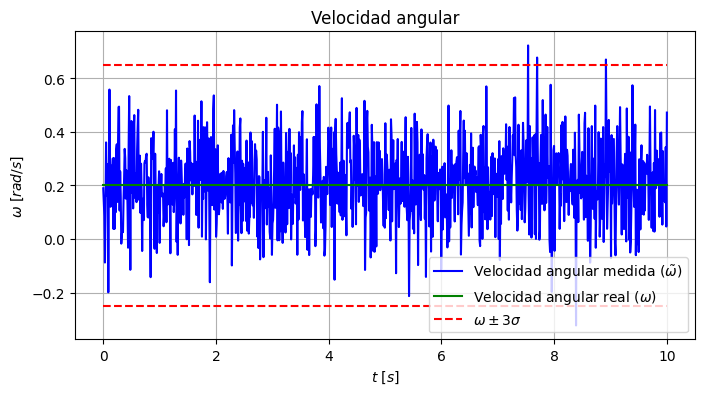

In [5]:
# Tamaño de la figura
plt.figure(figsize=(8,4))

# Gráfico de velocidad angular
plt.plot(t, w_medidos, 'b')
plt.plot(t, w_reales, 'g')

# Velocidad real +- 3 sigma
bias, sigma = gyro.get_params()
plt.plot(t, w_reales+3*sigma, 'r--')
plt.plot(t, w_reales-3*sigma, 'r--')

# Parámetros de la figura
plt.title('Velocidad angular')
plt.ylabel(r'$\omega$ [$rad/s$]')
plt.xlabel('$t$ [$s$]')
plt.legend([r'Velocidad angular medida ($\tilde{\omega}$)',
            r'Velocidad angular real ($\omega$)',
            r'$\omega\pm3\sigma$'])
plt.grid(); plt.show()

### 3.2. Gráfico de la Orientación

Se muestra el ángulo de orientación estimado ($\tilde\theta(t)$) y el ángulo real ($\theta(t)$), así como dos rectas que muestran el ángulo real $\pm$ 3 desviaciones estándar acumuladas: $\theta(t) \pm 3\sigma(t)$.

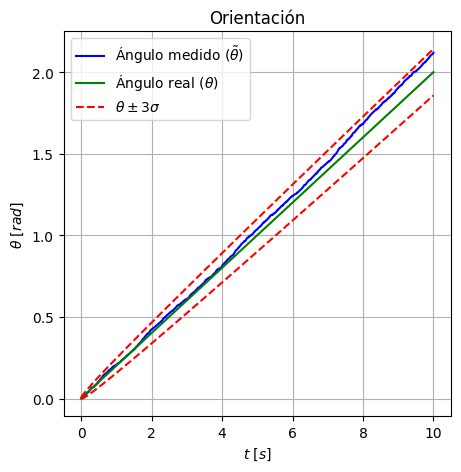

In [6]:
# Tamaño de la figura
plt.figure(figsize=(5,5))

# Gráfico de la orientación
plt.plot(t, thetas_estimados, color='blue')
plt.plot(t, thetas_reales, color='green')

# Gráfico de la orientación real +- 3 desv estándar
plt.plot(t, thetas_reales+3*sigmas_reales_acumulados, 'r--')
plt.plot(t, thetas_reales-3*sigmas_reales_acumulados, 'r--')

# Parámetros de la figura
plt.title('Orientación')
plt.ylabel(r'$\theta$ [$rad$]')
plt.xlabel('$t$ [$s$]')
plt.legend([r'Ángulo medido ($\tilde{\theta}$)',
            r'Ángulo real ($\theta$)',
            r'$\theta\pm3\sigma$'])
plt.grid(); plt.show()